In [3]:
import getpass
import os


def set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


set_env("ANTHROPIC_API_KEY")
set_env("BRAVE_API_KEY")

### Build a Basic Chatbot

In [26]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-haiku-20241022")
wawddwrrawawwwdwwwwwa
wa
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [28]:
graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

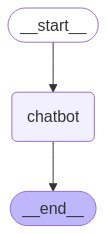

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: [{'text': "To provide you with accurate and up-to-date information about LangGraph, I'll need to search for the latest details. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_015S7XV5WM9BuyPL8p1E2G9n', 'input': {'query': 'LangGraph AI tool'}, 'name': 'brave_search', 'type': 'tool_use'}]
Assistant: "[{\"title\": \"LangGraph\", \"link\": \"https://langchain-ai.github.io/langgraph/\", \"snippet\": \"The <strong>LangGraph</strong> Platform consists of several components that work together to support the development, deployment, debugging, and monitoring of <strong>LangGraph</strong> applications: <strong>LangGraph</strong> Server (APIs), <strong>LangGraph</strong> SDKs (clients for the APIs), <strong>LangGraph</strong> CLI (command line <strong>tool</strong> for building the server), and ...\"}, {\"title\": \"How to Build AI Agents with LangGraph: A Step-by-Step Guide | by Lore Van Oudenhove | Medium\", \"link\": \"https://medium

### Enhancing the Chatbot with Tools

In [2]:
from langchain_community.tools import BraveSearch

api_key = os.environ["BRAVE_API_KEY"]

tool = BraveSearch.from_api_key(api_key=api_key, search_kwargs={"count": 3})
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

'[{"title": "Mastering LangGraph: A Beginner\'s Guide to Building Intelligent Language Models | Medium", "link": "https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141", "snippet": "Nodes: Nodes are <strong>the building blocks of your LangGraph</strong>. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making decisions, or interacting with external APIs."}, {"title": "LangGraph Glossary", "link": "https://langchain-ai.github.io/langgraph/concepts/low_level/", "snippet": "You define the behavior of your agents using three key components: State: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel. Nodes: <strong>Python functions that encode the logic of your agents</strong>."}, {"title": "LangGraph Tutorial: What Is LangGraph and How to Use It? | DataCamp", "link": "https://www.

In [3]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [4]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [5]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

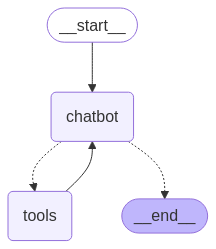

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: [{'text': "To answer your question about LangGraph, I'll need to search for the most up-to-date information. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01P2EYPBSDxLbhnSQqRQnCAY', 'input': {'query': 'LangGraph AI tool'}, 'name': 'brave_search', 'type': 'tool_use'}]
Assistant: "[{\"title\": \"LangGraph\", \"link\": \"https://langchain-ai.github.io/langgraph/\", \"snippet\": \"The <strong>LangGraph</strong> Platform consists of several components that work together to support the development, deployment, debugging, and monitoring of <strong>LangGraph</strong> applications: <strong>LangGraph</strong> Server (APIs), <strong>LangGraph</strong> SDKs (clients for the APIs), <strong>LangGraph</strong> CLI (command line <strong>tool</strong> for building the server), and ...\"}, {\"title\": \"How to Build AI Agents with LangGraph: A Step-by-Step Guide | by Lore Van Oudenhove | Medium\", \"link\": \"https://medium.com/@lorevanoudenh

### Adding Memory to the Chatbot

In [4]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [8]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools import BraveSearch
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

api_key = os.environ["BRAVE_API_KEY"]

tool = BraveSearch.from_api_key(api_key=api_key, search_kwargs={"count": 3})
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

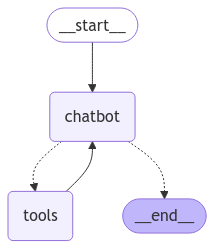

In [9]:
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?


In [11]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, I remember your name, Will. I'll be sure to address you by your name in our conversation. Is there anything in particular you'd like to talk about or any questions you have for me?


In [12]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I apologize, but I don't have any prior context or memory of your name. As an AI language model, I don't retain information from previous conversations or have personal memory. Each interaction starts fresh. If you'd like me to use a specific name for you during our conversation, please feel free to tell me what name you'd like me to use, and I'll be happy to refer to you by that name.


In [13]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='1ad175a6-3bb8-4c2a-baf8-be3da4db94b5'), AIMessage(content="Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?", additional_kwargs={}, response_metadata={'id': 'msg_01RcUUht4Zfm9cvbFendoTv8', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 379, 'output_tokens': 32}, 'model_name': 'claude-3-5-sonnet-20240620'}, id='run-42bbaf82-2f05-4d4c-8124-2a46381bd91b-0', usage_metadata={'input_tokens': 379, 'output_tokens': 32, 'total_tokens': 411, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='ec08518e-5091-4219-a6e1-331d7391a9fd'), AIMessage(content="Of course, I

In [14]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()